## Packages

In [26]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from load import load_new
import os
from glob import glob
import cv2 as cv

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [27]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_new()

In [28]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 192
Number of testing examples: 20
Each image is of size: (299, 299, 3)
train_x_orig shape: (192, 299, 299, 3)
train_y shape: (1, 192)
test_x_orig shape: (20, 299, 299, 3)
test_y shape: (1, 20)


In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (268203, 192)
test_x's shape: (268203, 20)


$268,203$ = $299 \times 299 \times 3$

## 2 layer NN

In [9]:
n_x = 268203     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [14]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.00375, num_iterations = 3000, print_cost=False):
    """
    Two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data
    Y -- true "label" vector
    layers_dims -- (n_x, n_h, n_y)
    num_iterations -- number of iterations
    learning_rate -- learning rate of gradient descent
    print_cost -- this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)

    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
     
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6898596591278783
Cost after iteration 100: 0.5930174137725355
Cost after iteration 200: 0.514070427927493
Cost after iteration 300: 0.4217621255746183
Cost after iteration 400: 0.34321664052289896
Cost after iteration 500: 0.14878819204578198
Cost after iteration 600: 0.08984431863208694
Cost after iteration 700: 0.05267043565501975
Cost after iteration 800: 0.03816580145342202
Cost after iteration 900: 0.031421643728130125
Cost after iteration 1000: 0.027441672033920395
Cost after iteration 1100: 0.02484612816415376
Cost after iteration 1200: 0.02307189892635047
Cost after iteration 1300: 0.02178594567281477
Cost after iteration 1400: 0.020751507725289768


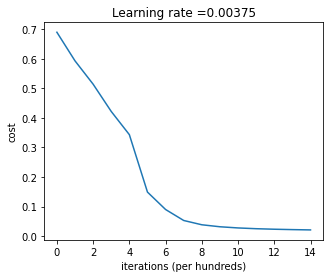

In [15]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 1500, print_cost=True)

In [16]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9791666666666667


In [17]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.55


## 4  L layer NN

In [6]:
layers_dims = [268203, 60, 30, 15, 1] #  4-layer model

In [7]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.00375, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID
    
    Arguments:
    X -- data
    Y -- true "label" vector
    layers_dims -- list containing the input size and each layer size
    learning_rate -- learning rate
    num_iterations -- number of iterations
    print_cost -- prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
    
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.710169
Cost after iteration 100: 0.609352
Cost after iteration 200: 0.504103
Cost after iteration 300: 0.431043
Cost after iteration 400: 0.364415
Cost after iteration 500: 0.300818
Cost after iteration 600: 0.066228
Cost after iteration 700: 0.029431
Cost after iteration 800: 0.016771
Cost after iteration 900: 0.011059
Cost after iteration 1000: 0.007986
Cost after iteration 1100: 0.006119
Cost after iteration 1200: 0.004878
Cost after iteration 1300: 0.003919
Cost after iteration 1400: 0.003296
Cost after iteration 1500: 0.002834
Cost after iteration 1600: 0.002477
Cost after iteration 1700: 0.002192
Cost after iteration 1800: 0.001960
Cost after iteration 1900: 0.001767
Cost after iteration 2000: 0.001605
Cost after iteration 2100: 0.001468
Cost after iteration 2200: 0.001350
Cost after iteration 2300: 0.001248
Cost after iteration 2400: 0.001159


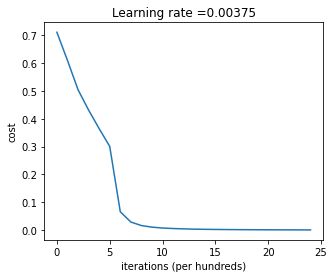

In [8]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [30]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [31]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.55
